In [1]:
import sys

sys.path.append("..")
import jabble.model
import jabble.dataset
import jabble.loss
import jabble.physics 
import astropy.units as u

import h5py
import matplotlib.pyplot as plt
import scipy.optimize

from jaxopt import GaussNewton
import jax.numpy as jnp
import jax
import numpy as np
from mpl_axes_aligner import align
import os
import jabble.physics

import jax.config

jax.config.update("jax_enable_x64", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
import os
import datetime

today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
file_b = h5py.File("../data/barnards_e2ds.hdf5", "r")
file_p = h5py.File("../data/51peg_e2ds.hdf5"   , "r")

In [19]:
file_p.keys()


<KeysViewHDF5 ['airms', 'bervs', 'data', 'dates', 'drifts', 'filelist', 'ivars', 'pipeline_rvs', 'pipeline_sigmas', 'xs']>

In [25]:
targ_vel = np.array(file_b['pipeline_rvs'])
targ_err = np.array(file_b['pipeline_sigmas'])
mjds = np.array(file_b['dates'])

In [5]:
def get_dataset(file,orders,device):
    ys = []
    xs = []
    yivar = []
    mask = []

    init_shifts = []
    airmass = []
    
    for iii in orders:
        for jjj in range(file["data"].shape[1]):
            ys.append(jnp.array(file["data"][iii,jjj,:]))
            xs.append(jnp.array(file["xs"][iii,jjj,:]))
            yivar.append(jnp.array(file["ivars"][iii,jjj,:]))
            mask.append(jnp.zeros(file["data"][iii,jjj,:].shape,dtype=bool))
            init_shifts.append(jabble.physics.shifts(file["bervs"][jjj]))
            airmass.append(file["airms"][jjj])
    
    init_shifts = jnp.array(init_shifts)
    airmass = jnp.array(airmass)
                         
    dataset = jabble.dataset.Data.from_lists(xs,ys,yivar,mask)
    dataset.to_device(device)
    init_shifts = jax.device_put(init_shifts,device)
    airmass = jax.device_put(airmass,device)

    return dataset, init_shifts, airmass

In [6]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")
loss = jabble.loss.ChiSquare()

In [10]:
class NewNormalizationModel(jabble.model.Model):
    def __init__(self, model, size):
        super(NewNormalizationModel, self).__init__()
        self.p     = jnp.tile(model.p,size)
        self.model = model

        self.model_p_size = len(model.p)
        self.size  = size

    def call(self, p, x, i, *args):
        # indices = self.get_indices(i)
        # parameters = 
        x = self.model.call(p.reshape(self.size,self.model_p_size)[i], x, i, *args)
        return x

In [17]:
order = 0
dataset_b, shifts_b, airmass_b = get_dataset(file_b,[order],cpus[0])
model_name_b = os.path.join('..','out','24-05-24','barnards_o{}.mdl'.format(order))
model_b = jabble.model.load(model_name_b)

5577 night sky line

6563 h alpha

In [13]:
model_b[1].__dict__

{'_fit': False,
 'func_evals': [],
 'history': [],
 'save_history': False,
 'loss_history': [],
 'save_loss': [],
 'results': [],
 'models': [<jabble.model.IrwinHallModel_vmap at 0x1525c0fc3090>,
 'parameters_per_model': Array([2722,    0], dtype=int64),
 'size': 2,
 '_param_bool': Array([[ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]], dtype=bool)}

In [14]:
model_b.display()

-AdditiveModel--------------------------------------------------7280
  0-CompositeModel----------------------------------------------3028
  0  0-ShiftingModel---------------------------------------------306
  0  1-IrwinHallModel_vmap--------------------------------------2722
  1-CompositeModel----------------------------------------------2722
  1  0-IrwinHallModel_vmap--------------------------------------2722
  1  1-StretchingModel---------------------------------------------0
  2-CompositeModel----------------------------------------------1530
  2  0-ShiftingModel---------------------------------------------306
  2  1-NewNormalizationModel------------------------------------1224


In [53]:
def f_info(self,model,data):
        """
        Get fischer information on parameters of the model. 
        Since each parameter is independent of all other epochs, fischer information matrix is diagonal, 
        thus returns this diagonal.

        Parameters 
        ----------
        model : `jabble.Model`
            The full model to evaluate.
        data : `jabble.Dataset`
            Data to be evaluate.

        Returns
        -------
        f_info : 'jnp.array`
            (N,) arry of diagonal of fischer information matrix.
        """
        f_info = np.zeros(self.n)
        model.fix()
        self.fit()
        model.display()
        for e_num in range(self.n):
            # print(np.sum(data.mask[e_num][:]))
            duddx = jax.jacfwd(model, argnums=0)(model.get_parameters(),data.xs[e_num][:],e_num) 
            f_info[e_num] = jnp.sum(jnp.where(~data.mask[e_num][:],(duddx[:,e_num]**2 * data.yivar[e_num][:]),0.0))
        return f_info

In [69]:
def rv_plot(model,data,targ_vel,targ_err,mjds,model_name):
    fig, ax = plt.subplots(
        1,
        figsize=(6, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
     
    epoches = len(data)
    epoch_range = np.arange(0, epoches, dtype=int)
    fischer_info = f_info(model[0][0],model,data)

    dvddx = jnp.array(
        [jax.grad(jabble.physics.velocities)(x) for x in model[0][0].p]
    )
    verr = np.sqrt(1 / fischer_info) * dvddx
    estimate_vel = jabble.physics.velocities(model[0][0].p)
    tv = targ_vel
    ev = estimate_vel
    ax.errorbar(
        mjds,
        tv,
        targ_err,
        fmt=".r",
        zorder=1,
        alpha=0.5,
        ms=6,
        label='HARPS RV'
    )
    print(np.mean(targ_vel),estimate_vel.mean())
    print(verr.shape,ev.shape)
    ax.errorbar(mjds,-ev,verr,fmt='.k',zorder=1,alpha=0.5,ms=6,label='Jabble RV')
    fig.legend()
    # ax.set_xlim(-0.5, epoches - 0.5)
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "MJD")
    plt.savefig(os.path.join(out_dir, "02-{}-vel.png".format(os.path.split(model_name))[-1]))
    plt.show()

-AdditiveModel---------------------------------------------------306
  0-CompositeModel-----------------------------------------------306
  0  0-ShiftingModel---------------------------------------------306
  0  1-IrwinHallModel_vmap-----------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-IrwinHallModel_vmap-----------------------------------------0
  1  1-StretchingModel---------------------------------------------0
  2-CompositeModel-------------------------------------------------0
  2  0-ShiftingModel-----------------------------------------------0
  2  1-NewNormalizationModel---------------------------------------0


/state/partition1/job-47055144/ipykernel_419748/875540265.py:17: RuntimeWarning: divide by zero encountered in divide
  verr = np.sqrt(1 / fischer_info) * dvddx


1.3030146315596463e-11 4335.216714850272
(306,) (306,)


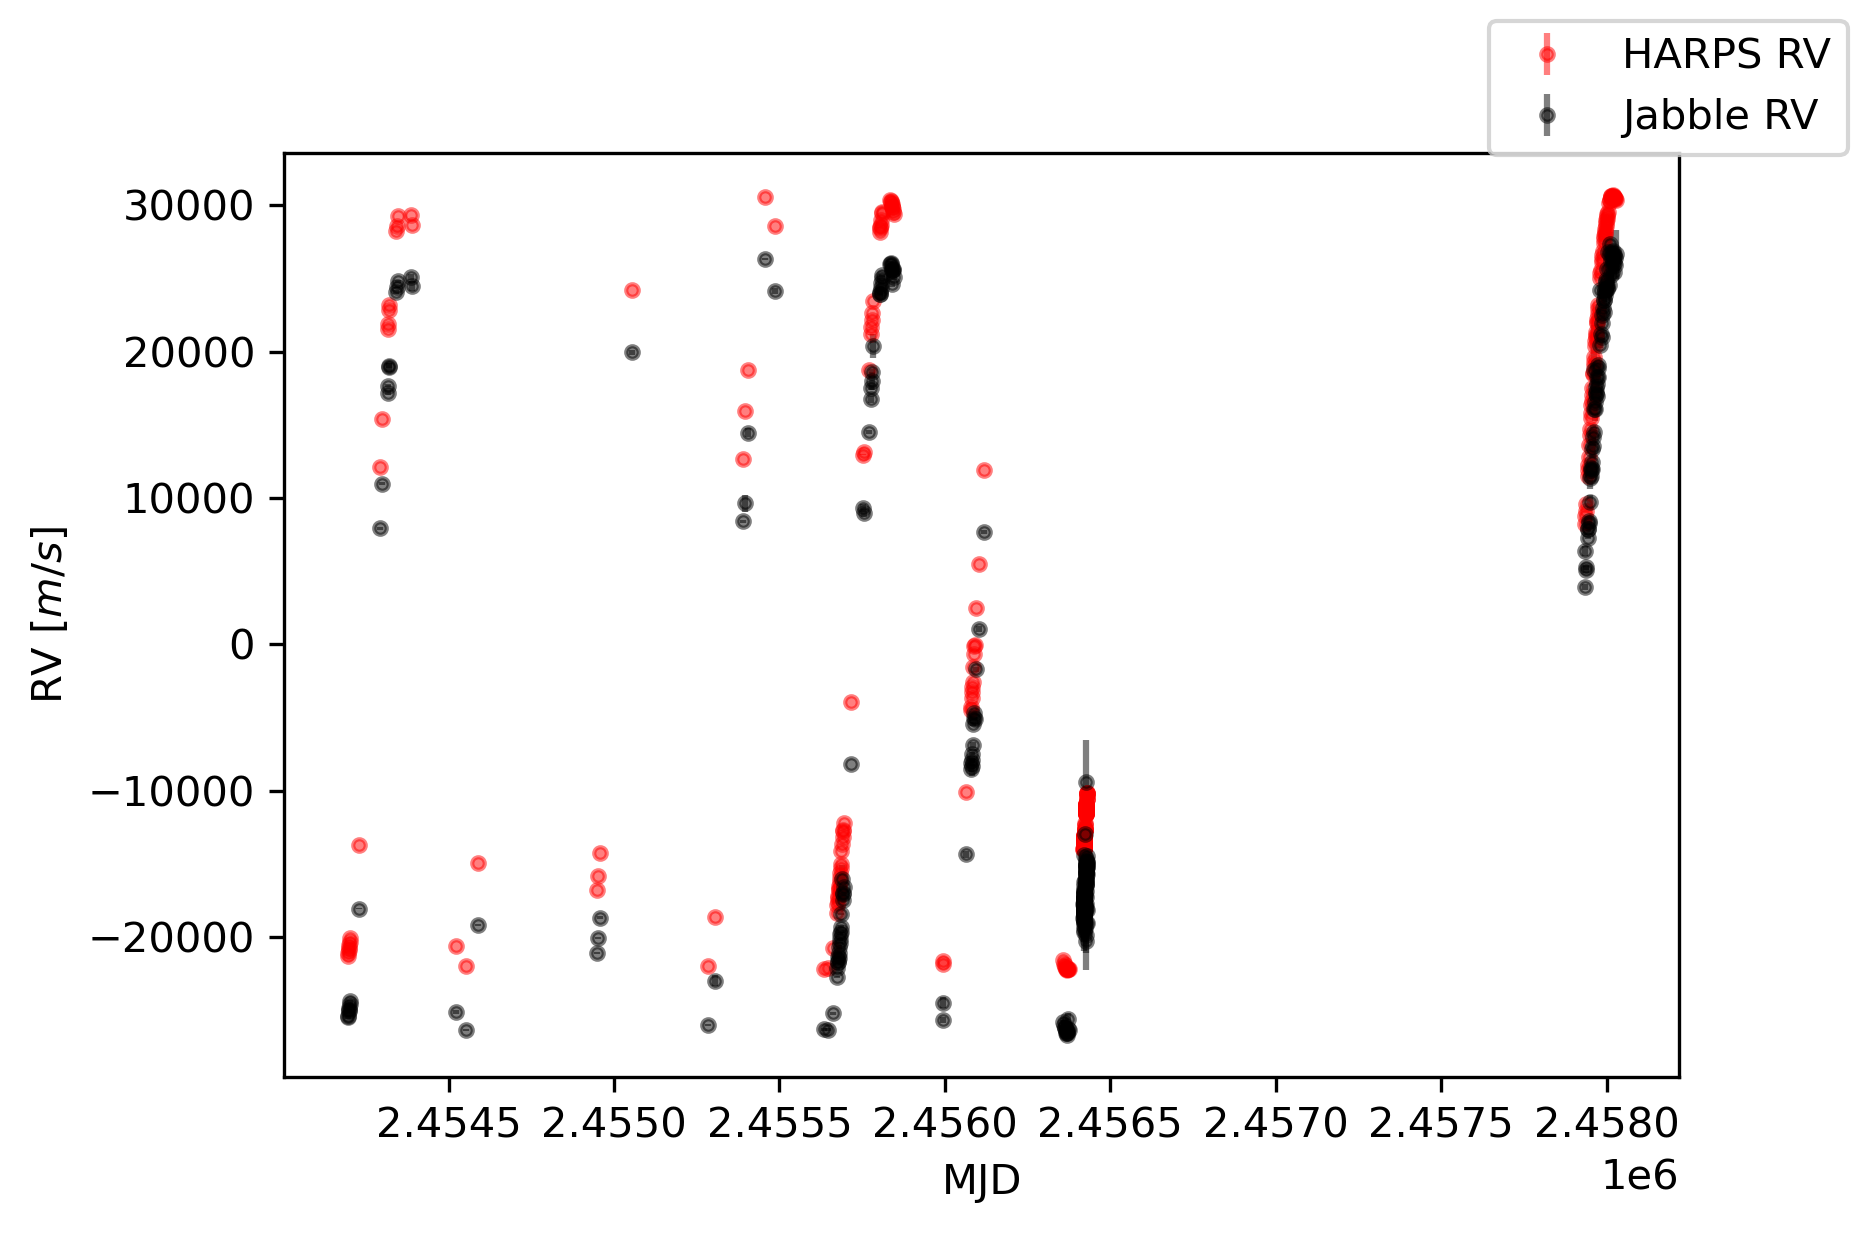

In [70]:
rv_plot(model_b,dataset_b,targ_vel,targ_err,mjds,model_name_b)

In [84]:
def make_bary_plot(model,dataset,plt_epoches,lmin,lmax,lrange,plt_name,bcs):
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),4),sharex=True,sharey='row',facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)
        
    model.fix()
    model.display()
    for ii, plt_epoch in enumerate(plt_epoches):
        
        xplot = np.linspace(np.log(lmin),np.log(lmax),\
                            dataset.xs[plt_epoch].shape[0]*10)
        yplot = model[2]([],xplot,plt_epoch)
        yplot_norm_stel = model[0]([],xplot,plt_epoch)
        yplot_norm_tell = model[1]([],xplot,plt_epoch)
        yhat = model[2]([],dataset.xs[plt_epoch],plt_epoch)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())

        velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
        # axes[0,ii].set_title('RV: {:2.1e}, $\delta\lambda$: {:2.1e}, BERV: {:2.1e}'.format(velocity,model[1][0].p[plt_epoch] * np.mean(lrange),bcs[plt_epoch]),fontsize=10)
        
        
    
        # Data
        # axes[0,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],\
        #                          '.k',zorder=1,alpha=0.1,ms=3)
        axes[0,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat,\
                                 '.k',zorder=1,alpha=0.1,ms=3)

        # Norm Model
        # axes[0,ii].plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        # axes[0,ii].set_ylim(-2+np.mean(yplot),0.1+np.mean(yplot))
        # print(np.mean(yplot))
        

        # Stellar Model        
        axes[0,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        # Telluric Model
        axes[0,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
        

        # Residuals
        axes[1,ii].step(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),\
                                 'k',where='mid',zorder=1,alpha=0.3,ms=3)
        
        axes[0,ii].set_ylim(-2,1)
        axes[1,ii].set_ylim(-0.1,0.1)
        axes[0,ii].set_xticks([])
        axes[0,ii].set_xticks(np.log(lrange))
        axes[0,ii].set_xticklabels(['{}'.format(x) for x in lrange])

    # plt.x
    # plt.text(1, 1, 'Wavelength ($\AA$)', ha='center')
    plt.savefig(plt_name,dpi=200,bbox_inches='tight')
    fig.suptitle('Barycentric Rest Frame')
    plt.show()

-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-ShiftingModel-----------------------------------------------0
  0  1-IrwinHallModel_vmap-----------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-IrwinHallModel_vmap-----------------------------------------0
  1  1-StretchingModel---------------------------------------------0
  2-CompositeModel-------------------------------------------------0
  2  0-ShiftingModel-----------------------------------------------0
  2  1-NewNormalizationModel---------------------------------------0


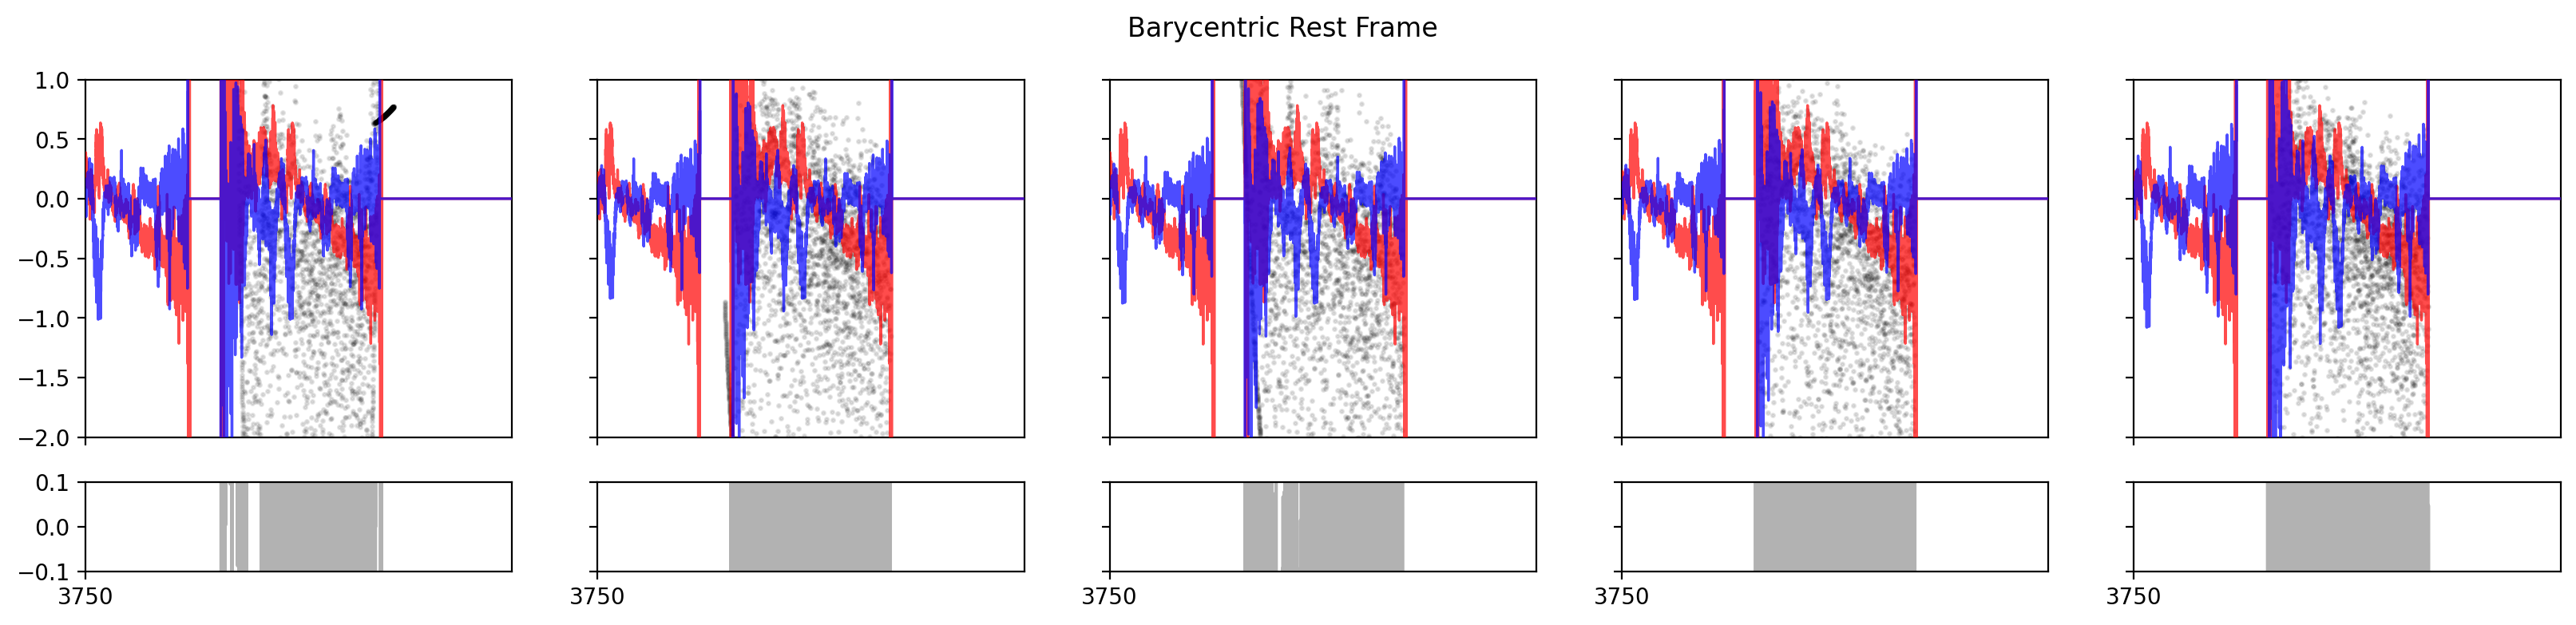

In [87]:
lmin = 3750
lmax = 3850
lspace = 200
lrange = np.arange(lmin,lmax,lspace)
plt_name = os.path.join(out_dir, "02-{}-spectra.png".format(os.path.split(model_name_b))[-1])
make_bary_plot(model_b,dataset_b,np.arange(10,15),lmin,lmax,lrange,plt_name,mjds)